# Initial set of functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle
plt.viridis()
%matplotlib inline


def lorentzian(Img, s = 50):
    return np.log(1.0 + s * Img**2)

def lorentzianLoss(Img, Ground, s = 50): 
    tImg = Img - Ground; 
    tImg -= np.mean(tImg); 
    return np.mean(np.log(1.0 + s*(tImg)**2))

def myMSE(Img, Ground): 
    tImg = Img - Ground; 
    tImg = np.square(tImg); 
    return np.mean(tImg)

def getVal(default):
    r = input().strip()
    if r == '':
        return default
    else:
        return r

In [2]:
def getScenes(fname):
    if (fname.find("rain") > 0):
        scenes = [line.strip() for line in open(dataPath + "train.txt", 'r')]
    elif (fname.find("est") > 0):
        scenes = [line.strip() for line in open(dataPath + "trueTest.txt", 'r')]
    elif (fname.find("idation") > 0): 
        scenes = [line.strip() for line in open(dataPath + "test.txt", 'r')]
    else: 
        print("Either training set or test set should be chosen.")
        raise ValueError("Noncompliant input: must be \"Train\" or \"Test\"") 
    print("%i scenes"%len(scenes))
    return scenes; 


def readTrainResults(rtf_descriptor, scene_name):
    groundTruth = np.loadtxt("%s/labels/%s.dlm"(dataPath, scene_name), delimiter='\t')
    allInputRTF = np.loadtxt("%s/images/%s.dlm"(dataPath, scene_name), delimiter='\t')
    inputRTF = allInputRTF[:, 8:1800:9]    # INPUT DONE (depth only)
    n = rtf_descriptor["name"]; c = rtf_descriptor["conn"]; d = rtf_descriptor["depth"]; 
    outputRTF = np.loadtxt("%s/%s RTFTrainedForMyLorentzian_%dx%d_%d.dlm"%(n, scene_name, c, c, d), delimiter='\t')
    return groundTruth, inputRTF, outputRTF

def readResults(rtf_descriptor, scene_name, cascadeSwitch = False):
    if (cascadeSwitch): 
        tname = "%s_2"%rtf_descriptor["name"]
    else: 
        tname = rtf_descriptor["name"]; 
    
    if (scene_name in testSet["scenes"]): 
        tname = "%s_test"%tname
    groundTruth = np.loadtxt("%s/%s Ground.dlm"%(tname, scene_name), delimiter='\t')
    # GT DONE
    allInputRTF = np.loadtxt("%s/%s Input.dlm"%(tname, scene_name), delimiter='\t') 
    inputRTF = allInputRTF[:, 8:1800:9]
    # INPUT DONE (depth only)
    outputRTF = np.loadtxt("%s/%s Prediction.dlm"%(tname, scene_name), delimiter='\t')
    #OUTPUT DONE    
    return groundTruth, inputRTF, outputRTF

In [3]:
# only RTF predictions are considered here. Training data are not loaded, but the change is trivial, if needed
def visualizeScene(rtf_descriptor, sceneName, cascadeConfig = False, deltaSwitch = True):
    if (not rtf_descriptor["cascade"].isdecimal() and cascadeConfig):
        print("RTF not configured for cascade opertaion. Terminating.")
        return None; 
    GT, iRTF, oRTF = readResults(rtf_descriptor, sceneName); 
    vmin, vmax = np.min(GT), np.max(GT); 
    if ( not cascadeConfig): 
        plt.figure(figsize=(14,3)); 
        plt.subplot(131); plt.imshow(iRTF, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Baseline (%s)"%float('%.5g' %lorentzianLoss(iRTF, GT)) ); plt.colorbar(); plt.axis('off')
        plt.subplot(132); plt.imshow(oRTF, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Prediction RTF (%s)"%float('%.5g' % lorentzianLoss(oRTF, GT)) ); plt.colorbar(); plt.axis('off')
        plt.subplot(133); plt.imshow(GT, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Ground Truth %s"%sceneName); plt.colorbar(); plt.axis('off')
        if( deltaSwitch): 
            plt.figure(figsize=(14,3)); 
            deltaIn = iRTF - GT; deltaIn -= np.mean(deltaIn); deltaIn = lorentzian(deltaIn); 
            deltaOut = oRTF - GT; deltaOut -= np.mean(deltaOut); deltaOut = lorentzian(deltaOut); 
            improv = deltaOut - deltaIn; vmindel = np.min(improv); vmaxdel = np.max(improv); 
            vmin, vmax = np.min((np.min(deltaIn), np.min(deltaOut))), np.max((np.max(deltaIn), np.max(deltaOut))); 
            plt.subplot(131); plt.imshow(deltaIn, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Loss Baseline"); plt.colorbar(); plt.axis('off')
            plt.subplot(132); plt.imshow(deltaOut, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Loss Prediction"); plt.colorbar(); plt.axis('off')
            plt.subplot(133); plt.imshow(improv, interpolation='nearest', vmin = vmindel, vmax = vmaxdel); plt.title("Difference"); plt.colorbar(); plt.axis('off')
    else: 
        GTc, iRTFc, oRTFc = readResults(rtf_descriptor, sceneName, cascadeSwitch = True);
        plt.figure(figsize=(14,10)); 
        vmin, vmax = np.min(GTc), np.max(GTc); 
        plt.subplot(221); plt.imshow(iRTF, interpolation='nearest', vmin=vmin, vmax=vmax); plt.axis('off'); plt.title("Baseline (%s)"%float('%.5g' % lorentzianLoss(iRTF, GT)) ); plt.colorbar(); 
        plt.subplot(222); plt.imshow(GT, interpolation='nearest', vmin=vmin, vmax=vmax); plt.axis('off'); plt.title("Ground Truth %s"%sceneName); plt.colorbar(); 
        plt.subplot(223); plt.imshow(oRTF, interpolation='nearest', vmin=vmin, vmax=vmax); plt.axis('off'); plt.title("Prediction RTF (%s)"%float('%.5g' % lorentzianLoss(oRTF, GT)) ); plt.colorbar();
        plt.subplot(224); plt.imshow(oRTFc, interpolation='nearest', vmin=vmin, vmax=vmax); plt.axis('off'); plt.title("Prediction Cascade (%s)"%float('%.5g' % lorentzianLoss(oRTFc, GT)) ); plt.colorbar(); 
        if (deltaSwitch):
            plt.figure(figsize=(14,10)); 
            deltaIn = iRTFc - GTc; deltaIn -= np.mean(deltaIn); deltaIn = lorentzian(deltaIn); 
            deltaOut = oRTF - GT; deltaIn -= np.mean(deltaOut); deltaOut = lorentzian(deltaOut)
            deltaOutc = oRTFc - GTc; deltaOutc -= np.mean(deltaOutc); deltaOutc = lorentzian(deltaOutc); 
            improv = deltaOut - deltaIn; vmindel = np.min(improv); vmaxdel = np.max(improv); 
            improvc = deltaOutc - deltaIn; vmindelc = np.min(improvc); vmaxdelc = np.max(improvc); 
            vmin, vmax = np.min((np.min(deltaIn), np.min(deltaOut), np.min(deltaOutc))), np.max((np.max(deltaIn), np.max(deltaOut), np.max(deltaOutc))); 
            plt.subplot(221); plt.imshow(deltaIn, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Loss Baseline"); plt.colorbar(); plt.axis('off')
            plt.subplot(222); plt.imshow(deltaOut, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Loss Prediction"); plt.colorbar(); plt.axis('off')
            plt.subplot(223); plt.imshow(improvc, interpolation='nearest', vmin=vmindel, vmax=vmaxdel); plt.title("Difference"); plt.colorbar(); plt.axis('off')
            plt.subplot(224); plt.imshow(deltaOutc, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Loss Cascade"); plt.colorbar(); plt.axis('off')
    plt.show() 

In [4]:
def saveScene(rtfexp_name, conn, depth, sceneName, deltaSwitch = True):
    GT, iRTF, oRTF = readResults(rtf_descriptor, sceneName); 
    vmin, vmax = np.min(GT), np.max(GT); 
    if ( not cascadeConfig): 
        plt.figure(figsize=(14,3)); 
        plt.subplot(131); plt.imshow(iRTF, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Baseline (%s)"%float('%.5g' %lorentzianLoss(iRTF, GT)) ); plt.colorbar(); plt.axis('off')
        plt.subplot(132); plt.imshow(oRTF, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Prediction RTF (%s)"%float('%.5g' % lorentzianLoss(oRTF, GT)) ); plt.colorbar(); plt.axis('off')
        plt.subplot(133); plt.imshow(GT, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Ground Truth %s"%sceneName); plt.colorbar(); plt.axis('off')
        plt.savefig('%s_RTF.png'%sceneName, bbox_inches='tight')
        if( deltaSwitch): 
            plt.figure(figsize=(14,3)); 
            deltaIn = iRTF - GT; deltaIn -= np.mean(deltaIn); deltaIn = lorentzian(deltaIn); 
            deltaOut = oRTF - GT; deltaOut -= np.mean(deltaOut); deltaOut = lorentzian(deltaOut); 
            improv = deltaOut - deltaIn; vmindel = np.min(improv); vmaxdel = np.max(improv); 
            vmin, vmax = np.min((np.min(deltaIn), np.min(deltaOut))), np.max((np.max(deltaIn), np.max(deltaOut))); 
            plt.subplot(131); plt.imshow(deltaIn, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Loss Baseline"); plt.colorbar(); plt.axis('off')
            plt.subplot(132); plt.imshow(deltaOut, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Loss Prediction"); plt.colorbar(); plt.axis('off')
            plt.subplot(133); plt.imshow(improv, interpolation='nearest', vmin = vmindel, vmax = vmaxdel); plt.title("Difference"); plt.colorbar(); plt.axis('off')
            plt.savefig('%s_RTF_delta.png'%sceneName, bbox_inches='tight')
    else: 
        GTc, iRTFc, oRTFc = readResults(rtf_descriptor, sceneName, cascadeSwitch = True);
        plt.figure(figsize=(14,10)); 
        vmin, vmax = np.min(GTc), np.max(GTc); 
        plt.subplot(221); plt.imshow(iRTF, interpolation='nearest', vmin=vmin, vmax=vmax); plt.axis('off'); plt.title("Baseline (%s)"%float('%.5g' % lorentzianLoss(iRTF, GT)) ); plt.colorbar(); 
        plt.subplot(222); plt.imshow(GT, interpolation='nearest', vmin=vmin, vmax=vmax); plt.axis('off'); plt.title("Ground Truth %s"%sceneName); plt.colorbar(); 
        plt.subplot(223); plt.imshow(oRTF, interpolation='nearest', vmin=vmin, vmax=vmax); plt.axis('off'); plt.title("Prediction RTF (%s)"%float('%.5g' % lorentzianLoss(oRTF, GT)) ); plt.colorbar();
        plt.subplot(224); plt.imshow(oRTFc, interpolation='nearest', vmin=vmin, vmax=vmax); plt.axis('off'); plt.title("Prediction Cascade (%s)"%float('%.5g' % lorentzianLoss(oRTFc, GT)) ); plt.colorbar(); 
        plt.savefig('%s_RTF_cascade.png'%sceneName, bbox_inches='tight')
        if (deltaSwitch):
            plt.figure(figsize=(14,10)); 
            deltaIn = iRTFc - GTc; deltaIn -= np.mean(deltaIn); deltaIn = lorentzian(deltaIn); 
            deltaOut = oRTF - GT; deltaIn -= np.mean(deltaOut); deltaOut = lorentzian(deltaOut)
            deltaOutc = oRTFc - GTc; deltaOutc -= np.mean(deltaOutc); deltaOutc = lorentzian(deltaOutc); 
            improv = deltaOut - deltaIn; vmindel = np.min(improv); vmaxdel = np.max(improv); 
            improvc = deltaOutc - deltaIn; vmindelc = np.min(improvc); vmaxdelc = np.max(improvc); 
            vmin, vmax = np.min((np.min(deltaIn), np.min(deltaOut), np.min(deltaOutc))), np.max((np.max(deltaIn), np.max(deltaOut), np.max(deltaOutc))); 
            plt.subplot(221); plt.imshow(deltaIn, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Loss Baseline"); plt.colorbar(); plt.axis('off')
            plt.subplot(222); plt.imshow(deltaOut, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Loss Prediction"); plt.colorbar(); plt.axis('off')
            plt.subplot(223); plt.imshow(improvc, interpolation='nearest', vmin=vmindel, vmax=vmaxdel); plt.title("Difference"); plt.colorbar(); plt.axis('off')
            plt.subplot(224); plt.imshow(deltaOutc, interpolation='nearest', vmin=vmin, vmax=vmax); plt.title("Loss Cascade"); plt.colorbar(); plt.axis('off')
            plt.savefig('%s_RTF_cascade_delta.png'%sceneName, bbox_inches='tight')
    plt.close(); 

In [5]:
def compareWithTV(rtf_descriptor, sceneName, weight, cascadeConfig = False): 
    if (not rtf_descriptor["cascade"].isdecimal() and cascadeConfig):
        print("RTF not configured for cascade opertaion. Terminating.")
        return None; 
    GT, iRTF, oRTF = readResults(rtf_descriptor, sceneName); 
    Dd_tv = denoise_tv_chambolle(iRTF, weight, multichannel=False); 
    plt.figure(figsize=(14,10)); 
    plt.subplot(221); plt.imshow(iRTF, interpolation='nearest'); plt.title("Baseline (%s)"%float('%.5g' %lorentzianLoss(iRTF, GT)) ); plt.colorbar(); plt.axis('off')
    plt.subplot(222); plt.imshow(GT, interpolation='nearest'); plt.title("Ground Truth %s"%sceneName); plt.colorbar(); plt.axis('off')
    plt.subplot(223); plt.imshow(Dd_tv, interpolation='nearest'); plt.title("Total Variation %s (%s)"%(weight, float('%.5g' %lorentzianLoss(Dd_tv, GT))) ); plt.colorbar(); plt.axis('off'); 
    if cascadeConfig:
        GTc, iRTFc, oRTFc = readResults(rtf_descriptor, sceneName, cascadeSwitch = True);
        plt.subplot(224); plt.imshow(oRTF, interpolation='nearest'); plt.title("Prediction Cascade (%s)"%float('%.5g' % lorentzianLoss(oRTFc, GT)) ); plt.colorbar(); plt.axis('off')
    else: 
        plt.subplot(224); plt.imshow(oRTF, interpolation='nearest'); plt.title("Prediction RTF (%s)"%float('%.5g' % lorentzianLoss(oRTF, GT)) ); plt.colorbar(); plt.axis('off')
    plt.show()

In [6]:
def writeStats(rtf_descriptor, setType, S): 
    n = rtf_descriptor["name"]; c = rtf_descriptor["conn"]; d = rtf_descriptor["depth"]; 
    nameStr = "%s/Evaluation_Results_RTFTrainedForMyLorentzian_%dx%d_%d_%s.txt"%(n, c, c, d, setType)
    np.savetxt(nameStr, S, delimiter='\t', fmt='%.8f'); 

def evaluateScenes(rtf_descriptor, sceneSet): 
    N = len(sceneSet["scenes"]); 
    totalLossForm = []; totalLossRTF = []; totalLossRTFC = []; 
    totalErrorForm = []; totalErrorRTF = []; totalErrorRTFC = []; 
    scKind = sceneSet["type"]; testsetType = (scKind == "Test"); 
    cascConfig = rtf_descriptor["cascade"].isdecimal(); 
    print("Number of scenes: %d. Type of set: %s"%(N, scKind))
    S = np.zeros((2 + N, 6)) 
    ii = 2; 
    for scene in sceneSet["scenes"]:
        GT, iRTF, oRTF = readResults(rtf_descriptor, scene); 
        formLoss = lorentzianLoss(GT, iRTF);
        currLoss = lorentzianLoss(GT, oRTF); 
        formError = myMSE(GT, iRTF)
        currError = myMSE(GT, oRTF)
        
        totalLossForm.append(formLoss); 
        totalLossRTF.append(currLoss); 
        totalErrorForm.append(formError); 
        totalErrorRTF.append(currError); 
        S[ii, :] = [formLoss, currLoss, 0, formError, currError, 0]
        if (cascConfig): 
            GT, iRTF, oRTFc = readResults(rtf_descriptor, scene, cascConfig); 
            currLossRTFC = lorentzianLoss(GT, oRTFc); 
            currErrorRTFC = myMSE(GT, oRTFc); 
            totalLossRTFC.append(currLossRTFC); 
            totalErrorRTFC.append(currErrorRTFC); 
            S[ii, 2] = currLossRTFC; S[ii, 5] = currErrorRTFC; 
            #saveScene(rtfexp_name, conn, depth, scene, True)
            #saveCascadeComparison(scene, rtfexp_name, conn, depth); 
        ii += 1; 
    print("%s mean loss: before @ %.5f, after @ %.5f"%(rtf_descriptor["name"], np.mean(totalLossForm), np.mean(totalLossRTF)))
    print("%s mean MSE:  before @ %.5f, after @ %.5f"%(rtf_descriptor["name"], np.mean(totalErrorForm), np.mean(totalErrorRTF)))


    S[0, 0] = np.mean(totalLossForm); S[0, 1] = np.mean(totalLossRTF); 
    S[0, 3] = np.mean(totalErrorForm); S[0, 4] = np.mean(totalErrorRTF)
    if (cascConfig):
        print("After cascade: \n\t Loss @ %.5f\t Error @ %.5f"%(np.mean(totalLossRTFC), np.mean(totalErrorRTFC))); 
        S[0, 2] = np.mean(totalLossRTFC); S[0, 5] = np.mean(totalErrorRTFC)
    return S

# Starting work now

In [7]:
print("Please enter path to data: [/Users/jvlatzko/Dropbox/Uni/Diplomarbeit/depth_data]")
dataPath = getVal("depth_data/ToF-data/wholeset/")
print("Folder of RTF prediction location [RTF_on_wellSepSets/]")
prescript = getVal("RTF_on_wellSepSets/"); 

trainSet, validationSet, testSet = {}, {}, {}; 

trainSet["type"] = "Train"; validationSet["type"] = "Validation"; testSet["type"] = "Test"; 
trainSet["scenes"] = getScenes("Train")
validationSet["scenes"]  = getScenes("Validation")
testSet["scenes"] = getScenes("Test")

Please enter path to data: [/Users/jvlatzko/Dropbox/Uni/Diplomarbeit/depth_data]

Folder of RTF prediction location [RTF_on_wellSepSets/]

130 scenes
21 scenes
51 scenes


In [8]:
rtf_descriptor = {}; 
defaultConn = 3; dC = defaultConn; 
defaultDepth = 13; dD = defaultDepth; 
defaultCascade = ""; dCa = defaultCascade; 
print("""Enter RTF experiment name, connectivity and depth (separate by return) 
      [%dx%d_%d, %d, %d]"""%(dC, dC, dD, dC, dD))
#RTF_experiment, RTF_connectivity, RTF_depth = getVal("3x3_13"), int(getVal("%d"%dC)), int(getVal("%d"%dD)), int(getVa) ; 
rtf_descriptor["name"], rtf_descriptor["conn"], rtf_descriptor["dep"] = getVal("3x3_13"), int(getVal("%d"%dC)), int(getVal("%d"%dD)) 

print("For cascaded configuration, enter stackdepth ['']")
rtf_descriptor["cascade"] = getVal("%s"%dCa); 

rtf_descriptor["name"] = prescript + rtf_descriptor["name"]

Enter RTF experiment name, connectivity and depth (separate by return) 
      [3x3_13, 3, 13]
3x3_13
3
13
For cascaded configuration, enter stackdepth ['']
2


In [9]:
rtf_descriptor

{'cascade': '2', 'conn': 3, 'dep': 13, 'name': 'RTF_on_wellSepSets/3x3_13'}

In [ ]:
## does not work on Mac, data not available 
#Strain = evaluateScenes(rtf_descriptor, trainSet)
#writeStats(rtf_descriptor, "train", Strain)

In [10]:
SvalC = evaluateScenes(rtf_descriptor, validationSet)

Number of scenes: 21. Type of set: Validation
RTF_on_wellSepSets/3x3_13 mean loss: before @ 0.41181, after @ 0.29921
RTF_on_wellSepSets/3x3_13 mean MSE:  before @ 0.15073, after @ 0.09226
After cascade: 
	 Loss @ 0.26148	 Error @ 0.08036


In [11]:
StestC = evaluateScenes(rtf_descriptor, testSet)

Number of scenes: 51. Type of set: Test
RTF_on_wellSepSets/3x3_13 mean loss: before @ 0.40904, after @ 0.25493
RTF_on_wellSepSets/3x3_13 mean MSE:  before @ 0.13707, after @ 0.07290
After cascade: 
	 Loss @ 0.21937	 Error @ 0.06446


# Visualisation of scenes (elements of test set)

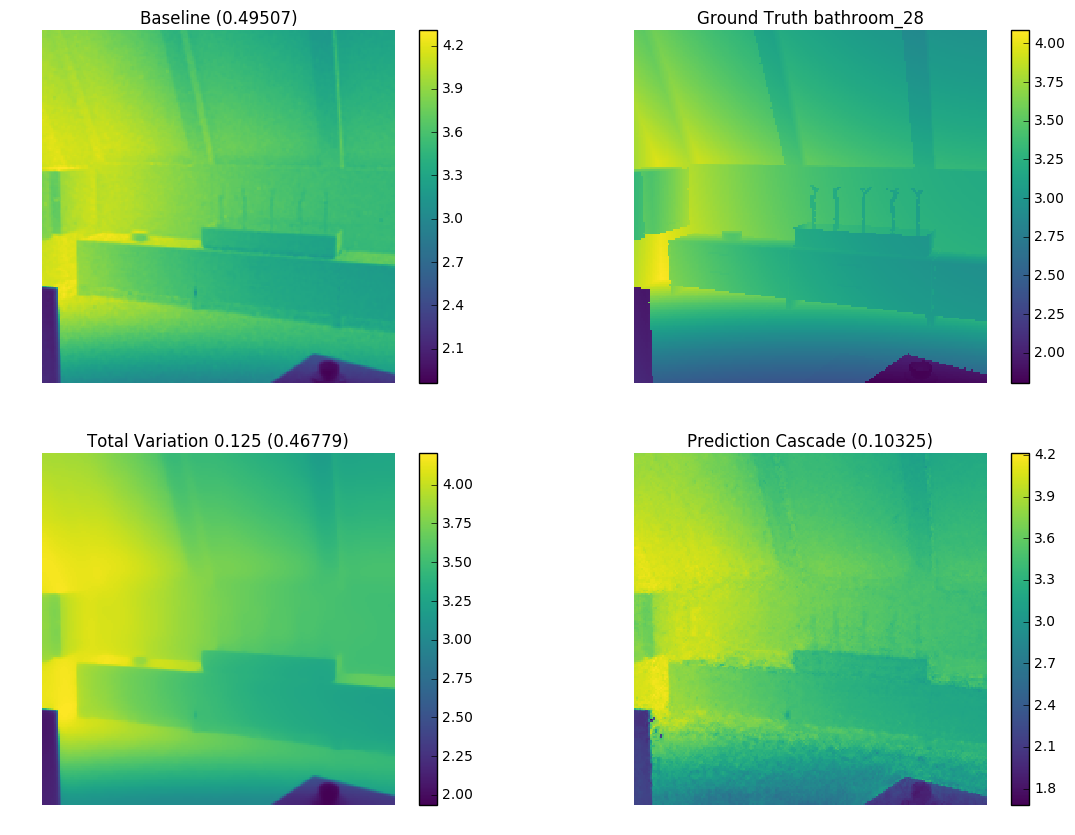

In [13]:
weightTV = 0.125
compareWithTV(rtf_descriptor, "bathroom_28", weightTV, True)

How many random scenes should be chosen for display? [4]
2


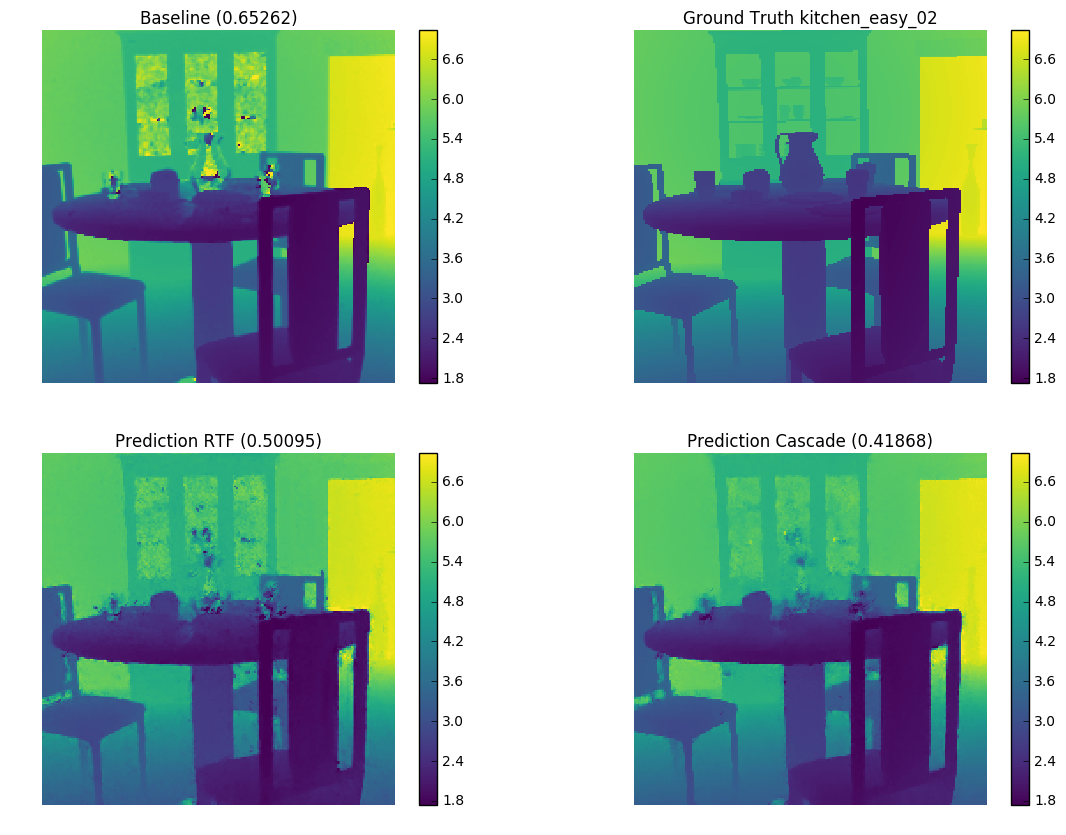

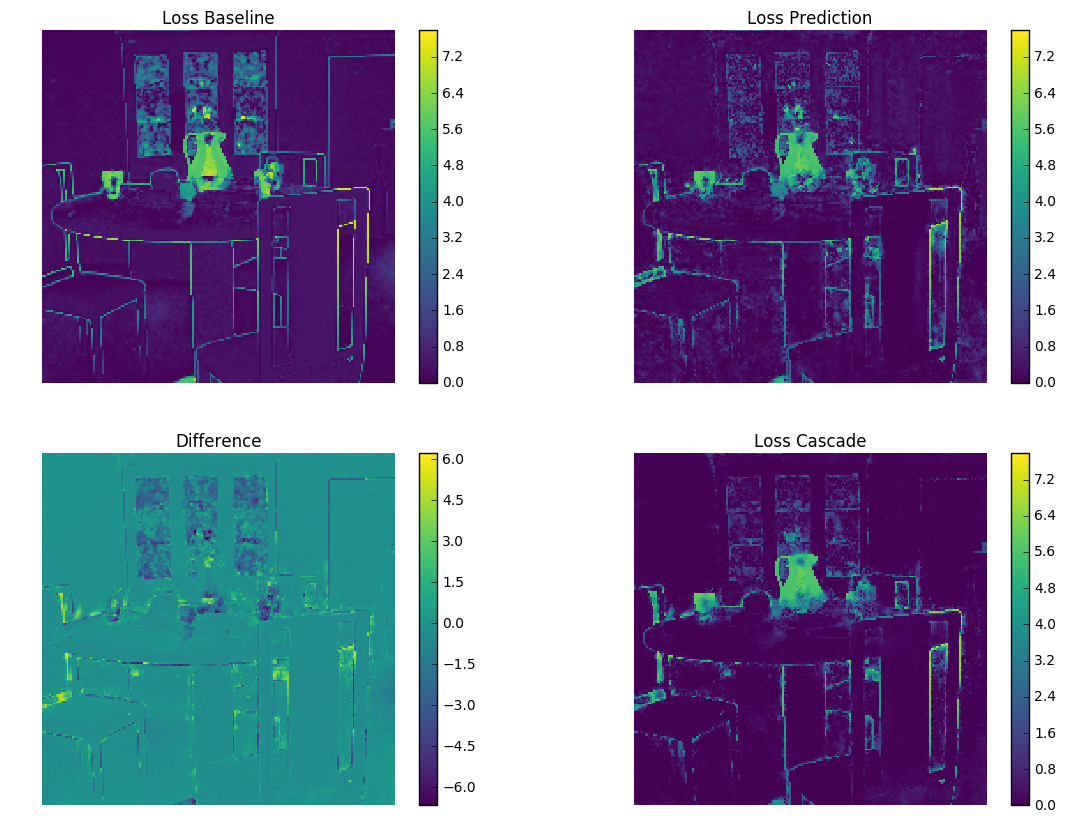

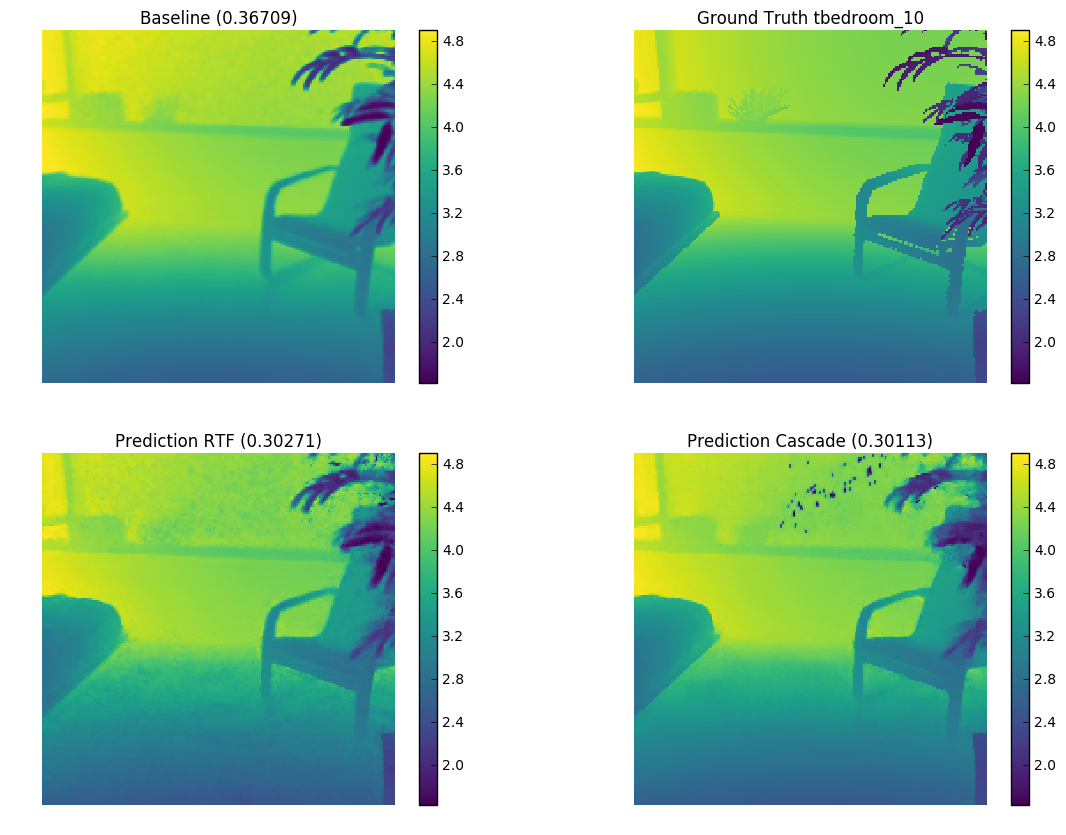

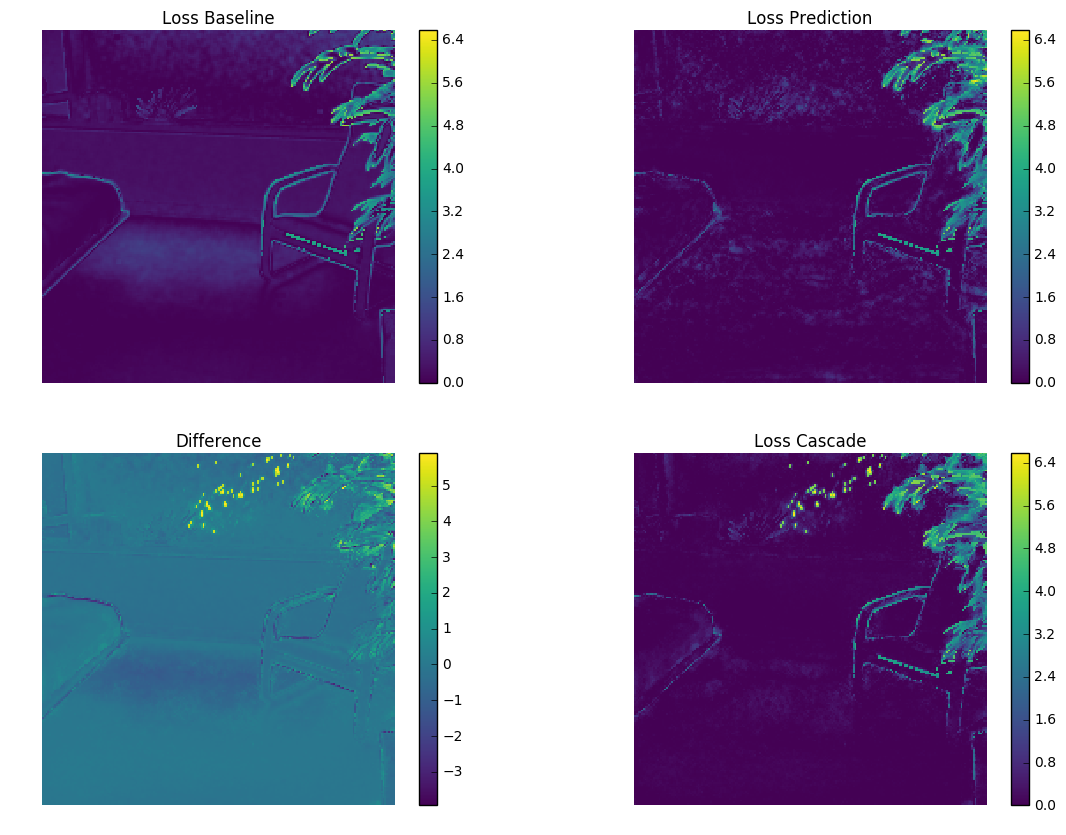

In [29]:
print("How many random scenes should be chosen for display? [4]")
n = int(getVal("4"))
for scene in np.random.permutation(testSet["scenes"])[0:int(n)]:
    visualizeScene(rtf_descriptor, scene, cascadeConfig=True, deltaSwitch=True);   